In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import re
from sklearn.feature_extraction.text import CountVectorizer
from wilds.common.data_loaders import get_train_loader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [12]:
def CleanText(text):
    text = re.sub(r'''[\[|\]]''', "", text).split()
    text = np.array(text, dtype="float64")
    return text

In [13]:
df = pd.read_csv("../CSVFiles/small50000DomainDataBertweetEmbedded.csv")

In [14]:
df = df.loc[:, ["comment_text", "split", "toxicity", "male", "female", "LGBTQ", "christian", "muslim", "other_religion", "black", "white"]]
df['comment_text'] = df['comment_text'].apply(lambda text: CleanText(text))

df['toxicity'] = df['toxicity'].apply(lambda text: np.round(text >= 0.5))
df['male'] = df['male'].apply(lambda x: np.round(x>=0.5))
df['female'] = df['female'].apply(lambda x: np.round(x>=0.5))
df['LGBTQ'] = df['LGBTQ'].apply(lambda x: np.round(x>=0.5))
df['christian'] = df['christian'].apply(lambda x: np.round(x>=0.5))
df['muslim'] = df['muslim'].apply(lambda x: np.round(x>=0.5))
df['other_religion'] = df['other_religion'].apply(lambda x: np.round(x>=0.5))
df['black'] = df['black'].apply(lambda x: np.round(x>=0.5))
df['white'] = df['white'].apply(lambda x: np.round(x>=0.5))

In [37]:
# Updating values for training_data
training_data = df[df['split'] == 'train']

# Getting test_data
test_data = df[df['split'] == 'test']

# Getting validation_data
validation_data = df[df['split'] == 'val']

In [38]:
X_train = training_data['comment_text'].values.tolist()
Y_train = training_data['toxicity'].values.tolist()

X_test = test_data['comment_text'].values.tolist()
Y_test = test_data['toxicity'].values.tolist()

X_val = validation_data['comment_text'].values.tolist()
Y_val = validation_data['toxicity'].values.tolist()

In [39]:
class AdalineGD():
    def __init__(self, learning_rate = 0.01, n_iter = 20, w = None):
        self.w = w
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        
    def CheckAccuracy(self, predictions, labels):
        acc = 0.0
        for i in range(len(predictions)):
            #print(predictions[i],labels[i])
            if (predictions[i] == labels[i]):
                acc += 1
        return acc/len(predictions)
    
    def predict(self, X_test):
        # Making sure that array is numpy array
        X_test = np.array(X_test).reshape((len(X_test), -1))
        output = np.dot(X_test, self.w)
        # Sigmoid giving 0-1 results
        
        preds = np.round(1/(1+np.exp(-output)))
        return preds
    
    def PredictTestSetDemographic(self, dfTest):
        dic = {}
        for col in dfTest.columns[3:]:
            tempSet = dfTest[dfTest[col] == 1]
            tempLabels = tempSet['toxicity'].values.tolist()
            tempVecs = tempSet['comment_text'].values.tolist()
            dic[col] = [tempVecs, tempLabels]
        
        f1_scores = []
        for col in dic:
            tempPredictions = self.predict(dic[col][0])
            currentF1 = f1_score(dic[col][1], tempPredictions, zero_division=1)
            f1_scores.append([currentF1, col])
        
        f1_scores = np.array(f1_scores)
        return f1_scores
        
    def fit(self, X_train, Y_train, X_val, Y_val):
        # Making sure that arrays are numpy arrays
        
        X_train = np.array(X_train).reshape((len(X_train), -1))
        Y_train = np.array(Y_train).reshape((len(Y_train), 1))
        
        X_val = np.array(X_val).reshape((len(X_val), -1))
        Y_val = np.array(Y_val).reshape((len(Y_val), 1))
        
        # Initializing w vector using random normal distribution
        if self.w == None:
            self.w = np.random.normal(0, 0.1, len(X_train[0])).reshape(len(X_train[0]), 1)
        
        badEpoch = 0
        self.bestW = self.w
        bestAcc = 0
        early_stopping = 150
        
        self.TrainAccArr_ = []
        self.ValAccArr_ = []
        
        # Using n epochs
        for i in range(self.n_iter):
            output = 1/(1+np.exp(-np.dot(X_train, self.w)))
            error = (Y_train - output)
            self.w += (1/len(Y_train)) * self.learning_rate * np.dot(X_train.T, error)
        
            tmpPredsVal = self.predict(X_val)
            valAcc = self.CheckAccuracy(tmpPredsVal, Y_val)
            self.ValAccArr_.append(valAcc)
            
            tmpPredsTrain = self.predict(X_train)
            TrainAcc = self.CheckAccuracy(tmpPredsTrain, Y_train)
            self.TrainAccArr_.append(TrainAcc)
            
            # Saving the best model and also checks for Early_Stopping
            if valAcc > bestAcc:
                bestAcc = valAcc
                badEpoch = 0
                self.bestW = self.w
            else:
                badEpoch += 1
            
            if badEpoch >= early_stopping:
                self.w = self.bestW                
                print("Stopped cause of bad Epoch in iteration: ", i)
                break
            #Print status
            if (i % 100) == 0:
                print('Iteration ', i, ' Done')
                
        self.TrainAccArr_ = np.array(self.TrainAccArr_)
        self.ValAccArr_ = np.array(self.ValAccArr_)
        self.w = self.bestW 
        return self

In [42]:
model = AdalineGD(learning_rate = 0.1, n_iter = 5000)

model.fit(X_train, Y_train, X_val, Y_val)

predictions = model.predict(X_test)
Y_test = np.array(Y_test).reshape(len(Y_test), 1)

model.CheckAccuracy(predictions, Y_test)

Iteration  0  Done
Iteration  100  Done
Iteration  200  Done
Iteration  300  Done
Iteration  400  Done
Iteration  500  Done
Iteration  600  Done
Iteration  700  Done
Iteration  800  Done
Iteration  900  Done
Iteration  1000  Done
Iteration  1100  Done
Iteration  1200  Done
Iteration  1300  Done
Iteration  1400  Done
Iteration  1500  Done
Iteration  1600  Done
Iteration  1700  Done
Iteration  1800  Done
Iteration  1900  Done
Iteration  2000  Done
Iteration  2100  Done
Iteration  2200  Done
Stopped cause of bad Epoch in iteration:  2262


0.7172185430463576

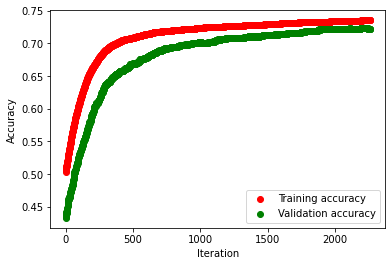

In [58]:
plt.figure()
plt.scatter(np.arange(0,len(model.TrainAccArr_)), model.TrainAccArr_, color='r', label='Training accuracy')
plt.scatter(np.arange(0,len(model.ValAccArr_)), model.ValAccArr_, color='g', label='Validation accuracy')
#plt.title("Training loss vs Validation loss")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.savefig('BaselineClassifier accuracy')
plt.show()

[['0.7429906542056075' 'male']
 ['0.7401247401247402' 'female']
 ['0.6556016597510373' 'LGBTQ']
 ['0.6097560975609757' 'christian']
 ['0.7166123778501629' 'muslim']
 ['0.6' 'other_religion']
 ['0.8333333333333333' 'black']
 ['0.7849223946784921' 'white']]


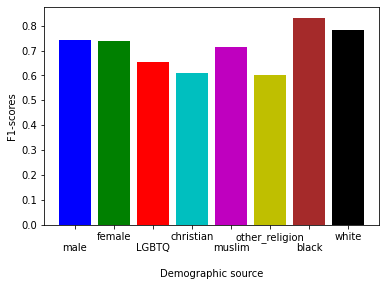

In [60]:
forBarPlot = model.PredictTestSetDemographic(test_data)
print(forBarPlot)
plt.figure()

x = forBarPlot[:,1]
for i in range(len(x)):
    if i%2 == 0:
        x[i] = "\n"+x[i]

y = np.array(forBarPlot[:,0].astype(float))

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, y, color=['b', 'g', 'r', 'c', 'm', 'y', 'brown', 'k'])
#plt.title('F1_scores across demographic groups')
plt.xlabel("\nDemographic source")
plt.ylabel("F1-scores")
plt.xticks(x_pos, x)
plt.savefig('FinalF1BaselineClassifier')
plt.show()

In [16]:
forBarPlot

array([['0.7214188883868052', 'LGBTQ'],
       ['0.8995584162862061', 'christian'],
       ['0.7603838441707247', 'muslim'],
       ['0.8362857142857143', 'other_religions'],
       ['0.6843185550082101', 'black'],
       ['0.7137658426402309', 'white']], dtype='<U32')

In [53]:
print(np.var(forBarPlot[:,0].astype(float)))
print(np.max(forBarPlot[:,0].astype(float)) - np.min(forBarPlot[:,0].astype(float)))

0.00599633837582925
0.23333333333333328


In [51]:
print("Antal toxic i predictions: ", sum(predictions))
print("Antal toxic i test set: ", sum(Y_test))
print("Samples i test set: ", len(Y_test))

Antal toxic i predictions:  [1030.]
Antal toxic i test set:  [1510.]
Samples i test set:  3020
